In [1]:
import pandas as pd
import numpy as np
import re
import tweepy
import datetime
from pandas_datareader import data as web
from textblob import TextBlob
from sklearn.svm import SVR
from treeinterpreter import treeinterpreter as ti
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as mlpt
from sklearn.model_selection import train_test_split

In [3]:
consumer_key = "W8olFrRLK7Lt7BUh6YAbdSG4h"
consumer_secret = "izRdiwC73rntSdMdAQm2gL8zFNAHVLa99A8dI99w0Lz16jvNrx"

access_token = "620364433-Kj5up6bB6KLfl5wfmxxcAnWthse5o38P2MKABM00"
access_token_secret = "Faxxv0hb54KF7MmakQ8WZmvaCC5YIprcWhiOuEyQY2iLt"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

fetch_tweets=tweepy.Cursor(api.search, q="#TSLA",count=100, lang ="en",since="2019-9-25", tweet_mode="extended").items()
data=pd.DataFrame(data=[[tweet_info.created_at.date(),tweet_info.full_text]for tweet_info in fetch_tweets],columns=['Date','Tweets'])

data.to_csv("TeslaTweets.csv")
cdata=pd.DataFrame(columns=['Date','Tweets'])
print("Created CSV")

Created CSV


In [4]:
index=0
for index,row in data.iterrows():
    stre=row["Tweets"]
    my_new_string = re.sub('[^ a-zA-Z0-9]', '', stre)
    cdata.sort_index()
    cdata.set_value(index,'Date',row["Date"])
    cdata.set_value(index,'Tweets',my_new_string)
    index=index+1
ccdata=pd.DataFrame(columns=['Date','Tweets'])

indx=0
get_tweet=""
for i in range(0,len(cdata)-1):
    get_date=cdata.Date.iloc[i]
    next_date=cdata.Date.iloc[i+1]
    if(str(get_date)==str(next_date)):
        get_tweet=get_tweet+cdata.Tweets.iloc[i]+" "
    if(str(get_date)!=str(next_date)):
        ccdata.set_value(indx,'Date',get_date)
        ccdata.set_value(indx,'Tweets',get_tweet)
        indx+=1
        get_tweet=" "
     
ccdata.to_csv('Tesla_tweets.csv')

C:\Users\Kamakshi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\Kamakshi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
C:\Users\Kamakshi\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Kamakshi\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


% of positive tweets=  88.88888888888889
% of negative tweets=  11.11111111111111


[]

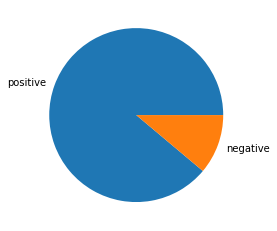

In [5]:
ccdata['polarity'] = 0.0000
for index,row in ccdata.iterrows():
    analysis = TextBlob(ccdata['Tweets'][index])
    sentiment, confidence  = analysis.sentiment
    ccdata.at[index,'polarity'] = sentiment
    
posi=0
nega=0
for i in range (0,len(ccdata)):
    get_val=ccdata['polarity'][i]
    if(float(get_val)<(0.01)):
        nega=nega+1
    else:
        posi=posi+1
        
posper=(posi/(len(ccdata)))*100
negper=(nega/(len(ccdata)))*100
print("% of positive tweets= ",posper)
print("% of negative tweets= ",negper)
arr=np.asarray([posper,negper], dtype=int)
mlpt.pie(arr,labels=['positive','negative'])
mlpt.plot()

In [19]:
start = datetime.datetime(2015,10,26)
## Let's get Apple stock data; Apple's ticker symbol is AAPL
## First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
tesla = web.DataReader('TSLA', 'yahoo', start)
tesla.to_csv('TESLA_stock_price.csv')

read_stock_p=pd.read_csv('TESLA_stock_price.csv')
print(len(read_stock_p))
ccdata['Prices']=""

indx=0
for i in range (0,len(ccdata)):
    for j in range (0,len(read_stock_p)):
        get_tweet_date=ccdata.Date.iloc[i]
        get_stock_date=read_stock_p.Date.iloc[j]
        if(str(get_stock_date)==str(get_tweet_date)):
            #print(get_stock_date," ",get_tweet_date)
            ccdata.set_value(i,'Prices',int(read_stock_p.Close[j]))
            break    


mean=0
summ=0
count=0
for i in range(0,len(ccdata)):
    if(ccdata.Prices.iloc[i]!=""):
        summ=summ+int(ccdata.Prices.iloc[i])
        count=count+1
mean=summ/count
for i in range(0,len(ccdata)):
    if(ccdata.Prices.iloc[i]==""):
        ccdata.Prices.iloc[i]=int(mean)

ccdata['Prices'] = ccdata['Prices'].apply(np.int64)
print(len(ccdata))


279
2019-12-05   2019-12-05
2019-12-04   2019-12-04
2019-12-03   2019-12-03
2019-12-02   2019-12-02
2019-11-29   2019-11-29
2019-11-27   2019-11-27
9

C:\Users\Kamakshi\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Kamakshi\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [18]:
X= np.array(ccdata['polarity'])
y= np.array(ccdata['Prices'].values).astype(float)

rf = SVR(kernel='linear' , C=1e-1)
(X_train,X_test,y_train,y_test) = train_test_split(X, y, test_size=0.2, random_state=1)
tp =rf.fit(X_train.reshape(-1,1), y_train)
prediction = tp.predict(X_test.reshape(-1,1))

In [14]:

##Compare the prediction and act
print(prediction) 
print(y_test)

[332.0003952  331.99997446]
[331. 336.]
